In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pdb
from Primacy_model import primacy_model

In [8]:
params_dict = {'P':11.5, 'D':0.27, 'T':0.49, 'M':0.1, 'N':0.05, 'vocab_size_PM':6, 'input_strength':50, 
                    'item_presentation_rate':0.4, 'blank':0.1, 'R': 4, 
                    'list_length': 6, 'output_time': 0.5, 'dt':0.005, 'save_folder': 'PM_figures/', 
                    'R_s':0.9}
PS = primacy_model(params_dict)

In [9]:
PS.simulate_trials_PM(num_trials=3000)

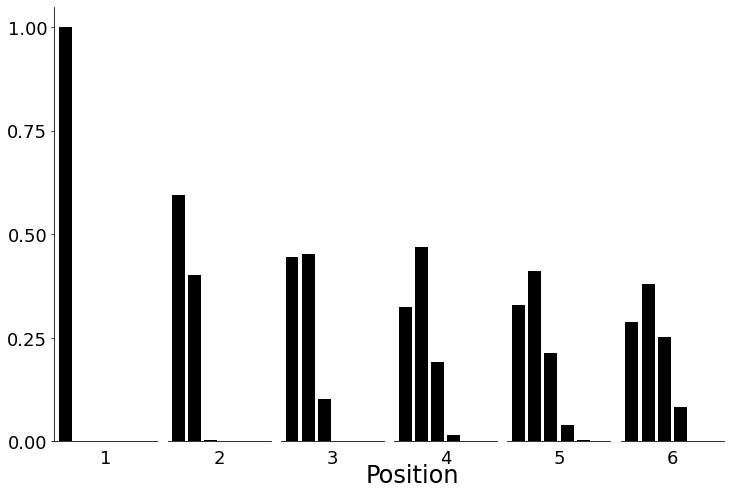

In [10]:
PS.plot_transposition_gradient(save_name='Transpositions_PM')

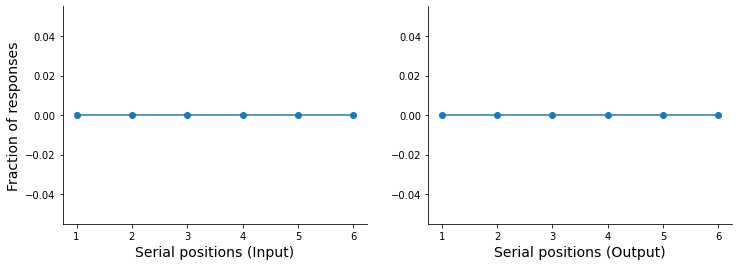

In [5]:
PS.plot_errors_inp_out('rep', frac_responses=True, save_name='PM_repetitions')

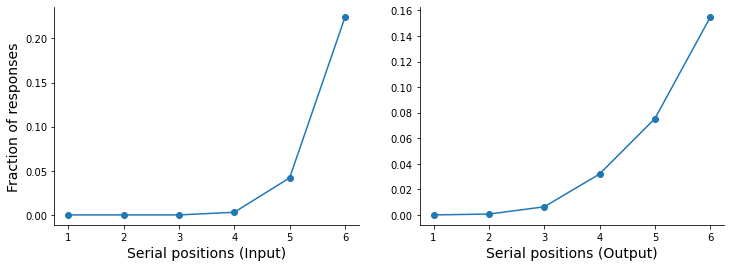

In [6]:
PS.plot_errors_inp_out('omi', frac_responses=True, save_name='PM_omissions_M_1_5')